# Generating Random Contour Maps

The idea is to create random terrains and subsequently generate contour maps off this terrain.

This is a [good survey of methods to build random terrains](http://blog.habrador.com/2013/02/how-to-generate-random-terrain.html). This page gives an in-depth description of a [simple algorithm to build random terrains](http://www.stuffwithstuff.com/robot-frog/3d/hills/hill.html) from robot-frog.

## Set up imports and constants

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator
%matplotlib inline

In [2]:
SIZE = 1024
NUM_ITERATIONS = 200

## Build random 2D hyperparameter space

In [3]:
terrain = np.zeros((SIZE, SIZE), dtype="float")
mod_iter = NUM_ITERATIONS // 10
for iter in range(NUM_ITERATIONS):
    if iter % mod_iter == 0:
        print("iteration: {:d}".format(iter))
    r = int(np.random.uniform(0, 0.2 * SIZE))
    xc, yc = np.random.randint(0, SIZE - 1, 2)
#     theta = 2 * np.pi * np.random.random_sample()
#     dist = ((SIZE / 2) - r) * np.random.random_sample()
#     x = (SIZE / 2) + dist * np.cos(theta)
#     y = (SIZE / 2) + dist * np.sin(theta)
    z = 0
    xmin, xmax = int(max(xc - r, 0)), int(min(xc + r, SIZE))
    ymin, ymax = int(max(yc - r, 0)), int(min(yc + r, SIZE))
    for x in range(xmin, xmax):
        for y in range(ymin, ymax):
            z = (r ** 2) - ((x - xc) ** 2 + (y - yc) ** 2)
            if z > 0: 
                terrain[x, y] += z
print("total iterations: {:d}".format(iter))

iteration: 0
iteration: 20
iteration: 40
iteration: 60
iteration: 80
iteration: 100
iteration: 120
iteration: 140
iteration: 160
iteration: 180
total iterations: 199


In [4]:
np.min(terrain), np.max(terrain)

(0.0, 282211.0)

In [5]:
copy = terrain.copy()

In [6]:
# normalize to unit height
zmin = np.min(terrain)
terrain -= zmin
zmax = np.max(terrain)
terrain /= zmax

In [7]:
# smooth the terrain by squaring the z values
terrain = np.power(terrain, 2)

In [8]:
# multiply by 255 so terrain can be visualized as grayscale image
terrain = terrain * 255
terrain = terrain.astype("uint8")
# convert mountains to valleys since stochastic gradient DESCENT
terrain = 255 - terrain

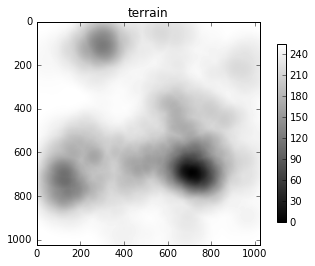

In [9]:
plt.title("terrain")
# image = plt.imshow(terrain, origin="upper", cmap="gray")
image = plt.imshow(terrain, cmap="gray")

plt.ylim(max(plt.ylim()), min(plt.ylim()))

# plt.xticks([])
# plt.yticks([])
plt.colorbar(image, shrink=0.8)

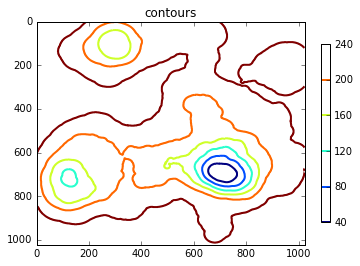

In [10]:
plt.title("contours")
contour = plt.contour(terrain, linewidths=2)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.colorbar(contour, shrink=0.8, extend='both')

## Grid Search (5x5)

In [11]:
# do a grid search (5x5)
results = []
for x in np.linspace(0, SIZE-1, 5):
    for y in np.linspace(0, SIZE-1, 5):
        xi, yi = int(x), int(y)
        results.append([xi, yi, terrain[xi, yi]])

best_xyz = [r for r in sorted(results, key=operator.itemgetter(2))][0]
grid_best = best_xyz[2]
print(best_xyz)

[767, 767, 109]


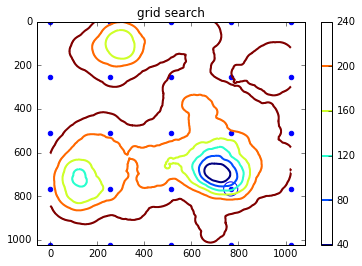

In [12]:
xvals = [r[0] for r in results]
yvals = [r[1] for r in results]

plt.title("grid search")
contour = plt.contour(terrain, linewidths=2)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.scatter(xvals, yvals, color="b", marker="o")
plt.scatter([best_xyz[0]], [best_xyz[1]], color='b', s=200, facecolors='none', edgecolors='b')
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.colorbar(contour)

## Random Search (25)

In [13]:
# do a random search
results = []
xvals, yvals, zvals = [], [], []
for i in range(25):
    x = np.random.randint(0, SIZE, 1)[0]
    y = np.random.randint(0, SIZE, 1)[0]
    results.append((x, y, terrain[x, y]))

best_xyz = sorted(results, key=operator.itemgetter(2))[0]
rand_best = best_xyz[2]
print(best_xyz)

(663, 618, 103)


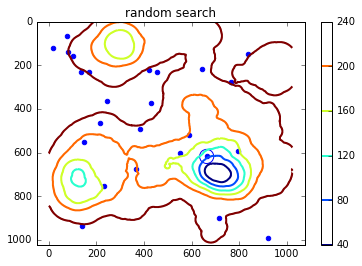

In [14]:
xvals = [r[0] for r in results]
yvals = [r[1] for r in results]

plt.title("random search")
contour = plt.contour(terrain, linewidths=2)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.scatter(xvals, yvals, color="b", marker="o")
plt.scatter([best_xyz[0]], [best_xyz[1]], color='b', s=200, facecolors='none', edgecolors='b')
plt.colorbar(contour)

## Batched Random Search

In [23]:
def cooling_schedule(n, k):
    """ reduces jitter window size at each run 
        n - number of batches
        k - index (0 based) of current batch
        returns multiplier (0..1) of SIZE
    """
    return (n - k) / n

results, winners = [], []
for bid in range(5):
    print("Batch #: {:d}".format(bid), end="")
    
    # compute window size
    window_size = int(0.25 * cooling_schedule(5, bid) * SIZE)

    # jitter the winners and add their values to results
    # at any point we will only keep the top 2 global winners
    for x, y, _, _ in winners:
        if x < SIZE // 2:
            # left of center
            xleft = max(x - window_size // 2, 0)
            xright = xleft + window_size
        else:
            # right of center
            xright = min(x + window_size // 2, SIZE)
            xleft = xright - window_size
        if y < SIZE // 2:
            # bottom half
            ybot = max(y - window_size // 2, 0)
            ytop = ybot + window_size
        else:
            # top half
            ytop = min(y + window_size // 2, 0)
            ybot = ytop - window_size
        xnew = np.random.randint(xleft, xright, 1)[0]
        ynew = np.random.randint(ybot, ytop, 1)[0]
        znew = terrain[xnew, ynew]
        results.append((xnew, ynew, znew, bid))
        
    # add remaining random points
    for i in range(5 - len(winners)):
        x = np.random.randint(0, SIZE, 1)[0]
        y = np.random.randint(0, SIZE, 1)[0]
        z = terrain[x, y]
        results.append((x, y, z, 2))

    # find the top 2 global winners
    winners = sorted(results, key=operator.itemgetter(2))[0:2]
    print(" best: ", winners[0])
    
#     print("results=", results)
#     print("winners=", winners)

best_xyz = sorted(results, key=operator.itemgetter(2))[0]
print(best_xyz)

Batch #: 0 best:  (707, 682, 20, 2)
Batch #: 1 best:  (707, 682, 20, 2)
Batch #: 2 best:  (707, 682, 20, 2)
Batch #: 3 best:  (707, 682, 20, 2)
Batch #: 4 best:  (707, 682, 20, 2)
(707, 682, 20, 2)


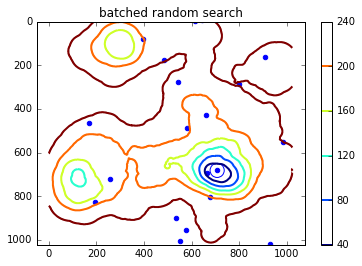

In [24]:
xvals = [r[0] for r in results]
yvals = [r[1] for r in results]

plt.title("batched random search")
contour = plt.contour(terrain, linewidths=2)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.scatter(xvals, yvals, color="b", marker="o")
plt.scatter([best_xyz[0]], [best_xyz[1]], color='b', s=200, facecolors='none', edgecolors='b')
plt.colorbar(contour)